# **Machine Learning II: Deep learning classifiers for urban sound data**
<img src="https://github.com/alfredofdlv/MCII-Project/blob/main_alfredo/images/portrait.png?raw=1" alt="Portrait" style="width:100%; height:auto;">

===================================================================================================================


## **Introduction**
Urban sound recognition is a crucial component in the development of intelligent systems for cities, supporting applications in public safety, environmental monitoring, and transportation. This project focuses on designing and evaluating deep learning classifiers for recognizing urban sounds using the UrbanSound8K dataset. This dataset contains audio samples across 10 classes commonly found in urban environments, such as "siren," "dog bark," and "street music." To address the classification challenge, we implement two neural network architectures: a **Recurrent Neural Network (RNN)**, which leverages temporal patterns in audio data, and a **Convolutional Neural Network (CNN)**, which captures spatial features within spectrogram representations of audio. By comparing these models, we aim to identify which architecture is more effective in urban sound classification tasks, balancing accuracy, computational efficiency, and model complexity.


### **Abstract**

This project presents a deep learning approach for urban sound classification, utilizing the UrbanSound8K dataset to train and evaluate two neural network models: a Recurrent Neural Network (RNN) and a **Convolutional Neural Network (CNN)**. Our data preparation pipeline applies comprehensive preprocessing steps, including signal normalization and feature extraction, to transform raw audio signals into structured representations suitable for deep learning input. Model architectures are iteratively optimized through careful adjustment of layer configurations, activation functions, and hyperparameters to enhance performance.
Training strategies incorporate fine-tuning of optimizers, regularization techniques, and a robust 10-fold cross-validation approach to ensure reliable generalization and mitigate overfitting. Model performance is evaluated using classification accuracy and a cumulative confusion matrix across folds, providing insight into each model’s ability to handle distinct sound classes.

Training strategies included fine-tuning of optimizers and regularization techniques, alongside a robust **10-fold cross-validation** to assess generalization. Classification performance is evaluated based on accuracy and the confusion matrix across folds, providing insights into each model's strengths in handling distinct sound classes.

### **Objective of the work**
The primary objective of this project is to develop and assess the efficacy of two distinct neural network architectures—RNN and CNN—for urban sound classification. By conducting a comparative analysis, we aim to provide understanding of each model's performance, identifying the trade-offs in accuracy, computational demands, and architectural complexity.

### **Structure of the work**
The project is structured into the following sections:

1. **Data pre-processing and preparation**: This section outlines the steps taken to preprocess the UrbanSound8K dataset. It includes methods for converting audio data into suitable features for the RNN and CNN models, specifically focusing on Mel-Frequency Cepstral Coefficients (MFCCs) for the RNN, which capture temporal patterns, and spectrograms for the CNN, which enable spatial feature extraction.
2. **Model Architectures**: A detailed description of the RNN and CNN models.
    - *RNN Architecture*: Explores the sequential processing layers of the RNN and includes comparisons of different submodels like LSTM and GRU, which capture temporal dependencies in audio features.
    - *CNN Architecture*: Describes the structure of the CNN model, emphasizing its ability to perform spatial feature extraction from spectrograms
3. **Training Strategies**: This section discusses the training approaches used for both models, including optimizers, regularization techniques, and adjustments for each model architecture.
4. **Evaluation Metrics**:  A description of the metrics used to evaluate model performance, including accuracy and confusion matrices.
5. **Deep Fool Strategy**: This section describes the use of the DeepFool algorithm to evaluate the robustness of the trained models against adversarial perturbations.
6. **Results and Discussion**: A presentation of the results obtained from the models, including accuracy and confusion matrix insights for each sound class, comparing the effectiveness of the RNN and CNN architectures.

## **Data pre-processing and preparation**

In [2]:
######## LIBRARIES ###############
import soundata
import librosa
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from importlib import reload
import utils
import pickle
import random
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from visualizations import analyze_audio_features


KeyboardInterrupt: 

### **Importing the data**

The UrbanSound8K Dataset contains 8,732 labeled sound clips (≤4 seconds each) spanning 10 urban sound classes: air conditioner, car horn, children playing, dog bark, drilling, engine idling, gun shot, jackhammer, siren, and street music. These classes represent a taxonomy of urban sounds, and each audio file is derived from field recordings uploaded to Freesound.org. Files are organized into ten predefined folds (fold1-fold10) for reproducibility and comparability of classification results.

Via the `soundata` library, in addition to the audio files in WAV format, a CSV metadata file, *UrbanSound8k.csv*, is provided. Key metadata includes:

- slice_file_name: Audio filename
- fsID: Original Freesound ID.
- start and end: Time range of the slice within the original recording.
- salience: Subjective salience rating (1 = foreground, 2 = background).
- fold: Predefined fold assignment (1-10).
- classID: Numeric class identifier (0-9).
- class: Name of the sound class.

We will also perform ***Exploratory Data Analysis(EDA)*** and data visualizations.

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

DATA_DIR = r'D:\Python_D\DeepLearningAudios'
dataset = soundata.initialize('urbansound8k', data_home = DATA_DIR)

metadata = pd.read_csv(os.path.join(DATA_DIR,"metadata","UrbanSound8k.csv"))
print(metadata.head(4))

# Display basic information
print("Dataset Info:")
metadata.info()
# Check for missing values
print("\nChecking for missing values:")
print(metadata.isnull().sum())


      slice_file_name    fsID  start        end  salience  fold  classID  \
0    100032-3-0-0.wav  100032    0.0   0.317551         1     5        3   
1  100263-2-0-117.wav  100263   58.5  62.500000         1     5        2   
2  100263-2-0-121.wav  100263   60.5  64.500000         1     5        2   
3  100263-2-0-126.wav  100263   63.0  67.000000         1     5        2   

              class  
0          dog_bark  
1  children_playing  
2  children_playing  
3  children_playing  
Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8732 entries, 0 to 8731
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   slice_file_name  8732 non-null   object 
 1   fsID             8732 non-null   int64  
 2   start            8732 non-null   float64
 3   end              8732 non-null   float64
 4   salience         8732 non-null   int64  
 5   fold             8732 non-null   int64  
 6   classID         

INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
C:\Users\Alejandro\AppData\Local\Temp\ipykernel_6196\2494736104.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x='fold', palette='viridis')
INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
C:\Users\Alejandro\AppData\Local\Temp\ipykernel_6196\2494736104.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x='class', order=d

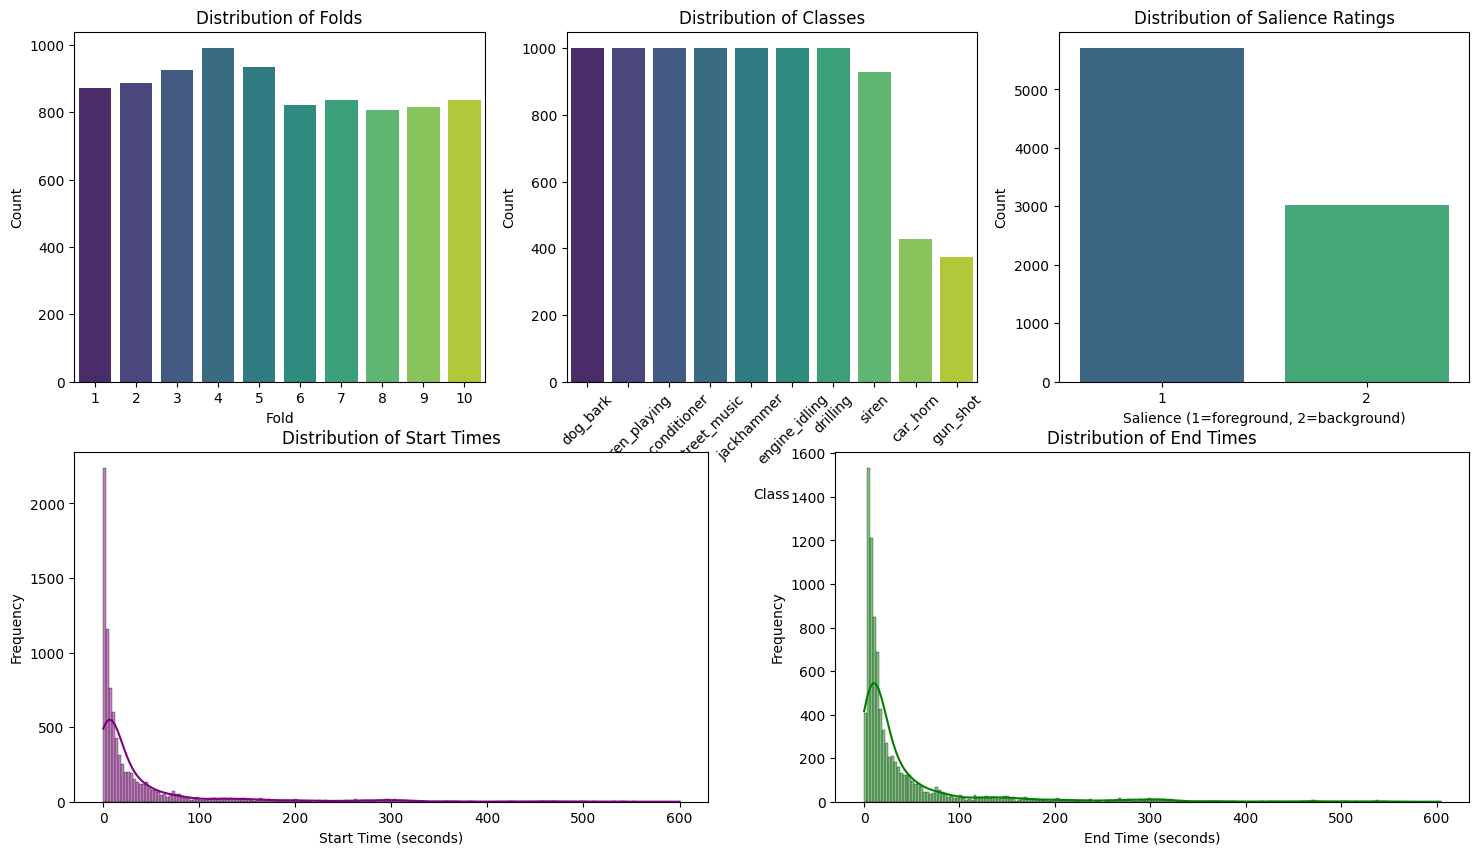

In [6]:
data = metadata


# Create a figure with a grid of subplots
plt.figure(figsize=(18, 10))

# Plot 1: Distribution of Folds
plt.subplot(2, 3, 1)
sns.countplot(data=data, x='fold', palette='viridis')
plt.title("Distribution of Folds")
plt.xlabel("Fold")
plt.ylabel("Count")

# Plot 2: Distribution of Classes
plt.subplot(2, 3, 2)
sns.countplot(data=data, x='class', order=data['class'].value_counts().index, palette='viridis')
plt.xticks(rotation=45)
plt.title("Distribution of Classes")
plt.xlabel("Class")
plt.ylabel("Count")

# Plot 3: Distribution of Salience Ratings
plt.subplot(2, 3, 3)
sns.countplot(data=data, x='salience', palette='viridis')
plt.title("Distribution of Salience Ratings")
plt.xlabel("Salience (1=foreground, 2=background)")
plt.ylabel("Count")

# Plot 4: Histogram of Start Times
plt.subplot(2, 2, 3)  # Adjusted for 2x2 grid starting from position 3
sns.histplot(data['start'], kde=True, color='purple')
plt.title("Distribution of Start Times")
plt.xlabel("Start Time (seconds)")
plt.ylabel("Frequency")

# Plot 5: Histogram of End Times
plt.subplot(2, 2, 4)  # Position adjusted for the last plot
sns.histplot(data['end'], kde=True, color='green')
plt.title("Distribution of End Times")
plt.xlabel("End Time (seconds)")
plt.ylabel("Frequency")

# Adjust layout to prevent overlap and add space between rows
plt.tight_layout()

plt.show()


In the dataset, as observed from the plots and summary statistics above, there are no missing data values. Additionally, the distribution of samples across the folds is relatively uniform, which supports balanced cross-validation. However, we do observe a class imbalance, particularly in the underrepresentation of the *car horn* and *gunshot* classes. Furthermore, a substantial portion of the data is labeled as foreground sounds, indicating that most audio samples have been annotated as prominent in the scene.

In [ ]:

# Agrupar datos por 'fold' y 'class' para contar el número de muestras
fold_class_counts = data.groupby(['fold', 'class']).size().unstack(fill_value=0)

# Configuración del gráfico de barras apiladas
plt.figure(figsize=(12, 8))
fold_class_counts.plot(
    kind='bar', 
    stacked=True, 
    colormap='tab20', 
    width=0.8, 
    edgecolor='black',
    ax=plt.gca()
)

# Añadir título y etiquetas a los ejes
plt.title("Class Distribution Across Folds", fontsize=16)
plt.xlabel("Fold", fontsize=14)
plt.ylabel("Sample Count", fontsize=14)

# Añadir leyenda para identificar las clases
plt.legend(title="Class", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mostrar el gráfico
plt.tight_layout()
plt.show()

![classdistracrossfold](images/class_distr_accross_folds.png)

To evaluate whether the classes are similarly distributed across folds, we can perform a hypothesis test of independence. This test will determine if there is a significant association between the variables fold and class, indicating whether the class distributions vary across folds. Chi-square test of independence :

- ($H_o$): The class distribution is the same across all folds (i.e., there is no association between fold and class).
- ($H_1$): The class distribution is not the same across folds (there is an association between fold and class).

In [44]:
import scipy.stats as stats

contingency_table = pd.crosstab(data['fold'], data['class'])
# Perform the Chi-square test of independence
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
print("Chi-square:", chi2)
print("Degrees of freedom:", dof)
print("P-value:", p)
# Interpret the result
alpha = 0.05
if p < alpha:
    print("We reject the null hypothesis: the class distribution differs across folds.")
else:
    print("We do not reject the null hypothesis: there is no significant evidence that the class distribution differs across folds.")

Chi-square: 192.2425218659076
Degrees of freedom: 81
P-value: 4.920225559810079e-11
We reject the null hypothesis: the class distribution differs across folds.


Since the p-value is extremely small, we have strong evidence to **reject the null hypothesis**. This means that the class distribution is not uniform across the folds. In other words, some folds may have an overrepresentation or underrepresentation of certain classes, which could affect the fairness of model evaluation.This class imbalance across folds can lead to skewed performance metrics, where certain folds may have an overrepresentation or underrepresentation of particular classes, impacting the model's ability to generalize effectively, as mentioned in the original paper of *Justin Salomon*.

Analyzing the performance of audio classification models across **foreground (FG) and background (BG)** labels provides valuable insights into their strengths and limitations. In the UrbanSound8K dataset, sound instances are labeled both by class and salience: FG sounds are prominent and easily distinguishable, while BG sounds often overlap with other audio sources or are less perceptually salient. 

This distinction is particularly significant because real-world audio classification is inherently noisy. Features like Mel-Frequency Cepstral Coefficients (MFCCs), commonly used in audio modeling, are highly sensitive to background noise and distortions. As a result, models relying on such features may perform better on FG-labeled samples, where the target sound is more isolated, compared to BG-labeled samples, which often involve overlapping or diffuse sounds. Investigating these differences can help us better understand the interplay between salience and model performance.

By examining FG and BG performance separately, we can pinpoint specific challenges, such as a model’s inability to generalize under noisy or complex conditions. These insights can inform the development of more robust algorithms. Advanced techniques like **DeepFool algorithms will be later on explored to evaluate classification in challenging BG scenarios**.

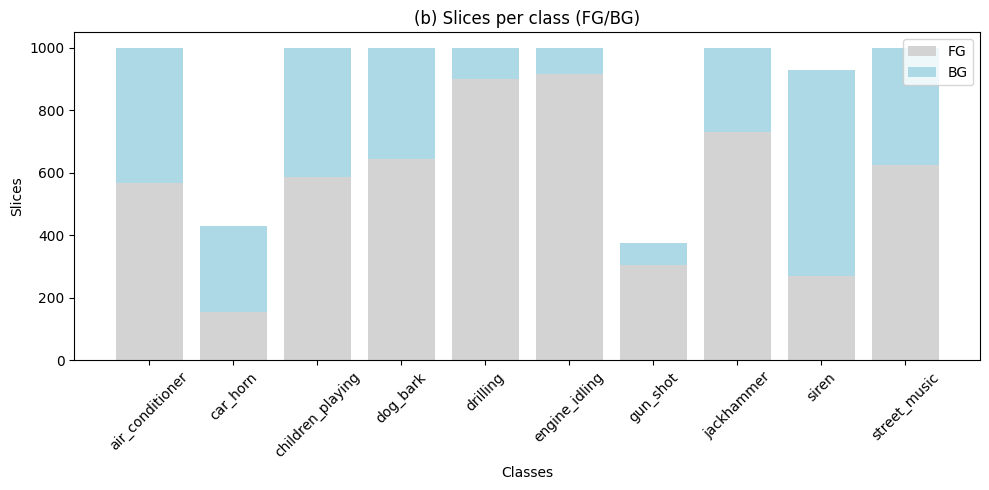

In [2]:
from visualizations import plot_urban_sound_slices
plot_urban_sound_slices()

### **Feature Extraction**

For our work with deep learning models, extracting relevant audio features is essential to ensure that the model receives inputs that can be effectively processed. According to `librosa` documentation, a specialized library for audio analysis, and the audio analysis papers mentioned in the bibliography, we decided to extract the low and high level spectral audio features:

- **Waveform**: The waveform is a simple representation of sound that captures the amplitude of an audio signal over time. While basic, it provides essential insight into the raw dynamics of the audio signal.

- **Zero Crossing Rate (ZCR)**: The Zero Crossing Rate measures how frequently the audio signal crosses the zero axis within a specified period. This feature is useful for detecting sudden changes in the signal's spectral characteristics.

- **Root Mean Square Energy (RMSE)**: RMSE calculates the quadratic mean of the energy in each frame of the audio signal. It is particularly useful for understanding variations in volume and intensity over time.

- **Mel-Frequency Cepstral Coefficients (MFCCs)**: MFCCs are derived from the spectrogram and are designed to model the human auditory system. These coefficients compress the audio data while preserving its most perceptually significant features. Widely used in audio and signal proccesing.

- **Spectral Centroid**: The spectral centroid represents the weighted average of the frequencies in the spectrum of an audio signal. It indicates where the majority of the spectral energy is concentrated, which correlates with the perceived brightness of the sound.

- **Spectral Bandwidth**: This feature measures the width of the frequency spectrum around the spectral centroid. It is helpful for distinguishing between complex sounds, such as noise, and more tonal sounds with a clear harmonic structure.

- **Spectral Rolloff**: Spectral rolloff marks the frequency below which a specified portion of the total spectral energy is contained. This feature is valuable for distinguishing between sharp, sudden sounds and steady, continuous ones, aiding in the classification of different types of audio events.

- **Mel Spectrogram**: A Mel spectrogram is a visual representation that illustrates how the frequency components of an audio signal change over time. It uses the Mel scale, which aligns more closely with human auditory perception

***Disclaimer: All features where extracted with the parameters used in the original Salomon´s paper*.**

A visual representation sample is shown below. 




d:\Python_D\DeepLearningAudios\MCII-Project\.venv\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


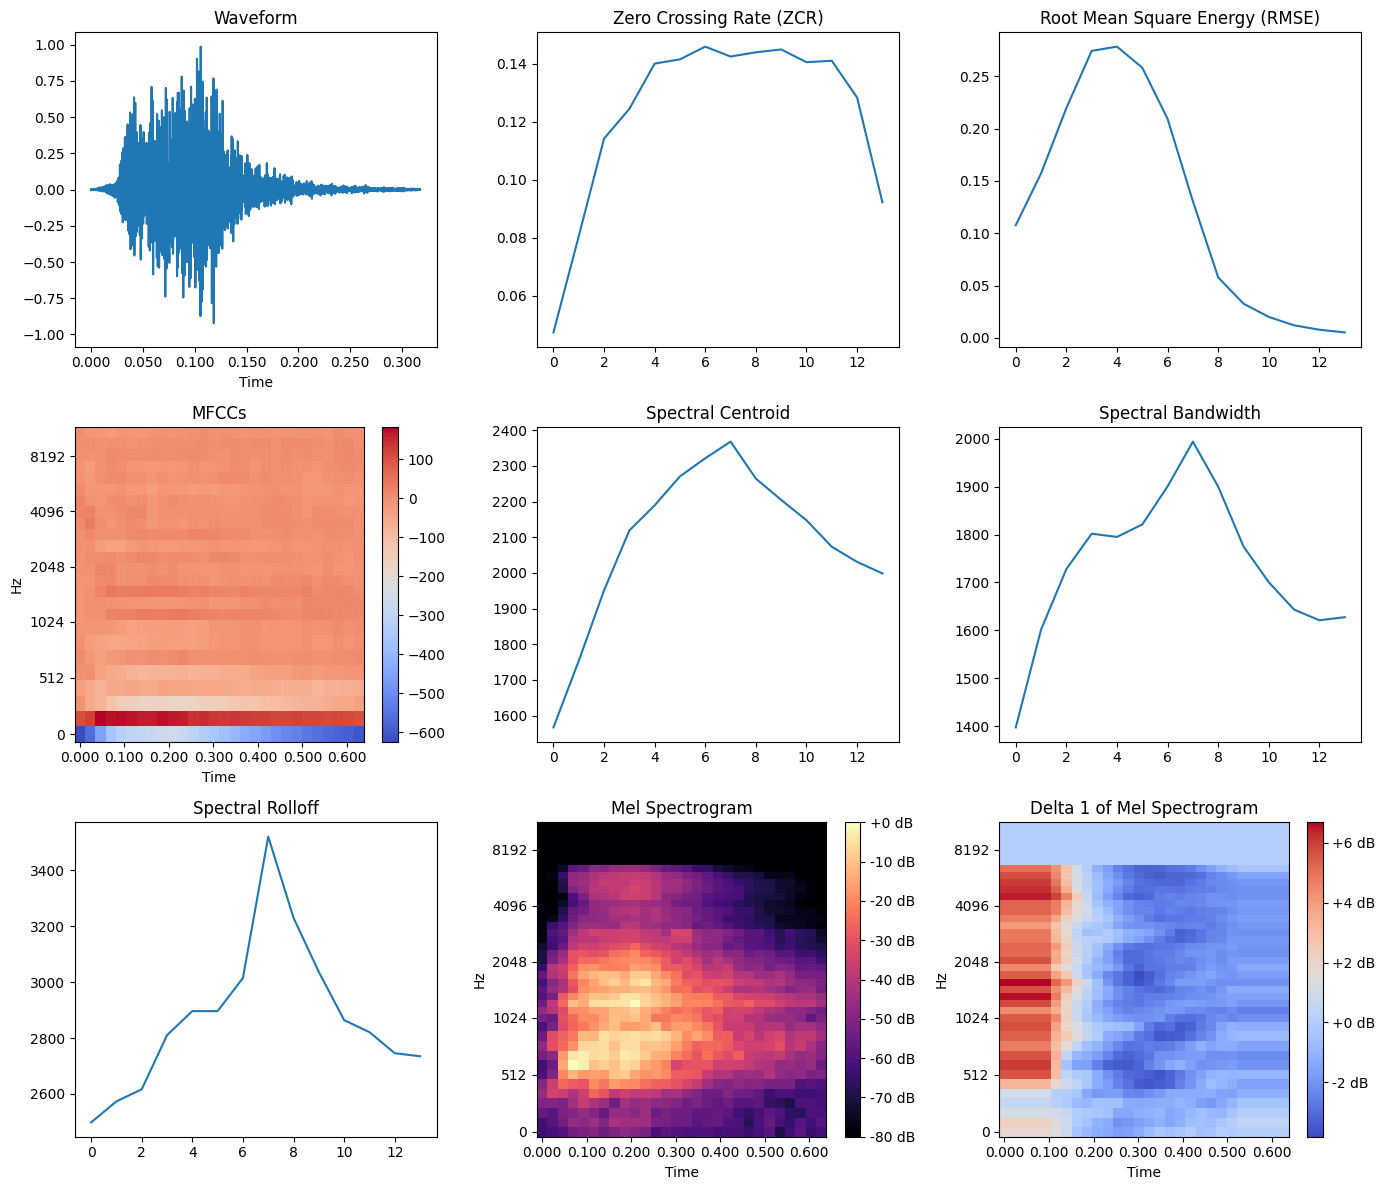

In [1]:
from visualizations import analyze_audio_features
import os
# Audio path file
DATA_DIR = r"D:\Python_D\DeepLearningAudios"
dir_audio_example = os.path.join(DATA_DIR, "audio", "fold5", "100032-3-0-0.wav")
analyze_audio_features(dir_audio_example)


After extracting the spectral features from the audio data, a post-processing step was performed. Specifically, it is important to note that not all features return arrays of the same length. Three main approaches could have been considered for addressing this issue:

**1. Padding the arrays:** This method extends shorter feature arrays by adding zeros or other padding values to achieve a uniform length. The advantage of this approach is that it ensures all feature arrays are of the same size, facilitating batch processing without data loss. However, the main disadvantage is that padding can introduce artificial data, which might degrade model performance, particularly when the padding significantly exceeds the actual signal length.

**2. Truncating the arrays to a minimum length:** This method involves cutting all feature arrays down to a predefined minimum length. The advantage is that it reduces the computational overhead and focuses on the most relevant parts of the signal. On the downside, truncation may discard important information, especially if the truncated portion of the signal contains critical acoustic features that are necessary for accurate classification.

**3. Repetition of the same sound to complete the 4-second length:** In this approach, the audio signal is repeated until it reaches the desired duration. The advantage is that it preserves the integrity of the original data, ensuring that feature arrays are consistent in length without discarding any part of the signal. However, the disadvantage is that repeating the same sound may introduce redundancy, which could negatively affect model generalization if the repeated sound is not representative of the full data distribution.

Each of these methods has its trade-offs in terms of data integrity, computational efficiency, and model performance. Finally, empirically, we decided that for the RNN we would opt for sound repetition, as it yielded better results, while for the CNN, a mix of truncation and padding would be used depending on the array length.

# **Model Architectures**
## Recurrent Neural Networks

****Recurrent Neural Networks (RNNs)**** is a type of neural network architecture designed to model sequential data, with the use of feedback loops it allows information to persist across time steps, helping retaining information about past dependencies. In traditional neural networks, th input and output layers were connected in a feed-forward manner, meaning information flew one way, from input to output, with no feedback.

In RNNs this is not the case, as it incorporates ****cyclic connections**** that enables continuous information flow throughout each step of the sequence. This structure allows the RNNs to capture and model temporal and contextual relationships over time effectively.



155.41842445114077


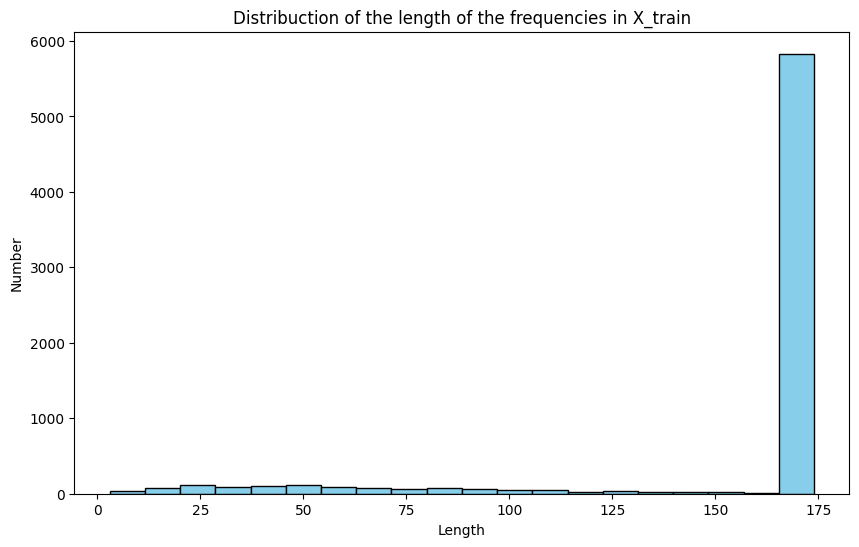

In [4]:
import numpy as np
import matplotlib.pyplot as plt
sequence_lengths = [len(seq) for seq in X_train]
print(np.mean(sequence_lengths))
# Graficar la distribución de longitudes de las secuencias
plt.figure(figsize=(10, 6))
plt.hist(sequence_lengths, bins=20, color='skyblue', edgecolor='black')
plt.title('Distribuction of the length of the frequencies in X_train')
plt.xlabel('Length')
plt.ylabel('Number')
plt.show()


In [5]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
sequence_lengths = [len(seq) for seq in X_train]
print(np.mean(sequence_lengths))

# Crear el codificador de etiquetas
label_encoder = LabelEncoder()

# Ajustar y transformar las etiquetas de entrenamiento
y_train_numeric = label_encoder.fit_transform(y_train)

# Transformar las etiquetas de prueba usando el mismo codificador
y_test_numeric = label_encoder.transform(y_test)

# Imprimir las clases asignadas
print("Clases:", label_encoder.classes_)


# Definir la longitud máxima deseada (por ejemplo, el máximo de tus secuencias o una longitud específica)
max_timesteps = max(sequence_lengths)  # Ajusta este valor según la longitud máxima de tus secuencias

# Aplicar padding
X_train_padded = pad_sequences(X_train, maxlen=max_timesteps, padding='post', dtype='float32')
X_test_padded = pad_sequences(X_test, maxlen=max_timesteps, padding='post', dtype='float32')

print(X_train_padded.shape)
"""
plt.hist(X_train_padded[:, 0, 4], bins=20)  # Selecciona una característica para visualizar
plt.title('Distribución después del escalamiento')
plt.show()
"""

# Verificar las dimensiones de los datos después del padding
print("Forma de X_train después de padding:", X_train_padded.shape)
print("Forma de X_test después de padding:", X_test_padded.shape)

num_classes = len(np.unique(y_train))

# Convertir etiquetas de y_train y y_test a one-hot encoding
y_train = to_categorical(y_train_numeric, num_classes=num_classes)
y_test = to_categorical(y_test_numeric, num_classes=num_classes)



155.41842445114077
Clases: ['air_conditioner' 'car_horn' 'children_playing' 'dog_bark' 'drilling'
 'engine_idling' 'gun_shot' 'jackhammer' 'siren' 'street_music']


d:\Python_D\DeepLearningAudios\MCII-Project\.venv\lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\Python_D\DeepLearningAudios\MCII-Project\.venv\lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


(6969, 174, 153)
Forma de X_train después de padding: (6969, 174, 153)
Forma de X_test después de padding: (1763, 174, 153)


In [6]:
import importlib
import models
importlib.reload(models)
from models import ImprovedGRUModel,AudioLSTM,AttGRUModel


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, f1_score, recall_score
import matplotlib.pyplot as plt
from models import ComplexGRUModel,ComplexLSTMModel,ImprovedGRUModel,AudioLSTM,AttGRUModel
from visualizations import plot_DL_results

# Verificar si hay GPUs disponibles
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device.type == 'cuda':
    print(f"Entrenando en GPU: {torch.cuda.get_device_name(0)}")
else:
    print("No hay GPUs disponibles. El entrenamiento se realizará en la CPU.")
""" 
# Definir los parámetros del modelo
input_dim = X_train_padded.shape[2]  # Número de características de entrada
hidden_dim = 256  # Dimensiones ocultas
output_dim = 10  # Número de salidas (ajustar según necesidad)
n_layers = 2  # Número de capas LSTM
dropout_rate = 0.03  # Tasa de dropout

# Inicializar el modelo
model = AudioLSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, n_layers=n_layers, dropout_rate=dropout_rate).to(device)


# Inicialización del modelo
model = ComplexLSTMModel(input_dim=X_train_padded.shape[2], 
                        hidden_dim1=128,   # Reducir el tamaño de las capas
                        hidden_dim2=64, 
                        hidden_dim3=64, 
                        output_dim=10,dropout_rate=0.1).to(device)

# Inicialización del modelo GRU
model = ComplexGRUModel(input_dim=X_train_padded.shape[2], # antes era 2
                        hidden_dim1=32,   # Reducir el tamaño de las capas
                        hidden_dim2=18, 
                        hidden_dim3=8, 
                        output_dim=10,dropout_rate=0.01).to(device)
"""

# Inicialización del modelo GRU
model = ImprovedGRUModel(input_dim=X_train_padded.shape[2], # antes era 2
                        hidden_dim1= 16,   # Reducir el tamaño de las capas
                        hidden_dim2= 16,
                        output_dim=10,dropout_rate=0.01).to(device)
"""
model = AttGRUModel(input_dim=X_train_padded.shape[2], # antes era 2
                        hidden_dim1= 64,   # Reducir el tamaño de las capas
                        hidden_dim2= 64,
                        output_dim=10,dropout_rate=0.03,num_heads=4).to(device)
"""
# Definir el optimizador con regularización L2 (weight decay)
optimizer = optim.Adam(model.parameters(), lr=0.0005)# weight_decay=1e-4

criterion = nn.CrossEntropyLoss()

# Preparación de datos (convertir etiquetas y inputs en tensores)
y_train2 = torch.tensor(y_train).argmax(dim=1).to(device)
train_data = TensorDataset(torch.tensor(X_train_padded, dtype=torch.float32).to(device), y_train2)
train_loader = DataLoader(train_data, batch_size=32, shuffle=False)

# Convertir X_test y y_test a tensores y moverlos a la GPU
y_test2 = torch.tensor(y_test)  # Convertir de numpy.ndarray a torch.Tensor
y_test2 = torch.argmax(y_test2, dim=1)  # Convertir a índices si es one-hot
y_test2 = y_test2.to(device)  # Mover a la GPU

# Crear el DataLoader para los datos de prueba
test_data = TensorDataset(
    torch.tensor(X_test_padded, dtype=torch.float32).to(device),  # Mover los datos de entrada de prueba a la GPU
    y_test2  # Las etiquetas de prueba ya están en la GPU
)
test_loader = DataLoader(test_data, batch_size= 32, shuffle=False)

# Definición de la función de entrenamiento

epochs = 100
# Entrenar el modelo
train_losses, valid_losses, train_accuracies, train_f1_scores, train_recalls, valid_accuracies, valid_f1_scores, valid_recalls = train_model(
    model, train_loader, criterion, optimizer, epochs = epochs)

# Graficar las métricas
epochs_range = range(1, epochs+1)


# Llamada a la función para graficar los resultados
plot_DL_results(
    train_accuracies=train_accuracies,
    valid_accuracies=valid_accuracies,
    train_losses=train_losses,
    valid_losses=valid_losses,
    train_f1_scores=train_f1_scores,
    valid_f1_scores=valid_f1_scores,
    train_recalls=train_recalls,
    valid_recalls=valid_recalls,
    epochs_range=epochs_range
)

Entrenando en GPU: NVIDIA GeForce RTX 3060
Epoch 1/100 - Loss: 2.3041 - Train Accuracy: 0.1230 - Train F1: 0.0561 - Train Recall: 0.1230 - Valid Loss: 2.2161 - Valid Acc: 0.1656
Epoch 2/100 - Loss: 2.2098 - Train Accuracy: 0.1841 - Train F1: 0.1461 - Train Recall: 0.1841 - Valid Loss: 2.1636 - Valid Acc: 0.2564
Epoch 3/100 - Loss: 2.1619 - Train Accuracy: 0.2653 - Train F1: 0.2388 - Train Recall: 0.2653 - Valid Loss: 2.1170 - Valid Acc: 0.3193
Epoch 4/100 - Loss: 2.1219 - Train Accuracy: 0.3167 - Train F1: 0.2911 - Train Recall: 0.3167 - Valid Loss: 2.0714 - Valid Acc: 0.3607
Epoch 5/100 - Loss: 2.0841 - Train Accuracy: 0.3454 - Train F1: 0.3173 - Train Recall: 0.3454 - Valid Loss: 2.0225 - Valid Acc: 0.3823
Epoch 6/100 - Loss: 2.0462 - Train Accuracy: 0.3627 - Train F1: 0.3334 - Train Recall: 0.3627 - Valid Loss: 1.9781 - Valid Acc: 0.4005
Epoch 7/100 - Loss: 2.0086 - Train Accuracy: 0.3903 - Train F1: 0.3584 - Train Recall: 0.3903 - Valid Loss: 1.9354 - Valid Acc: 0.4078
Epoch 8/100 

KeyboardInterrupt: 

## **Convolutional Neural Networks(CNN)**

In [1]:
import importlib
import utils
importlib.reload(utils)
import os 
from utils import  get_zerocr,repeat_sound,create_dataset2,generate_train_set
DATA_DIR = r"D:\Python_D\DeepLearningAudios"
dir_audio_example = os.path.join(DATA_DIR, "audio", "fold5", "100032-3-0-0.wav")

r = get_zerocr(dir_audio_example)

In [2]:
from utils import create_dataset,generate_train_set
import pandas as pd 
trFolds, testFolds = generate_train_set(train = 8)
df = pd.read_csv(r'D:\Python_D\DeepLearningAudios\metadata\UrbanSound8k.csv')
directory_audio = r'D:\Python_D\DeepLearningAudios\audio'
X_train, X_test, y_train, y_test = create_dataset2(directory_audio, df,trFolds,testFolds) 

d:\Python_D\DeepLearningAudios\MCII-Project\.venv\lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1103
  warnings.warn(
d:\Python_D\DeepLearningAudios\MCII-Project\.venv\lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(
d:\Python_D\DeepLearningAudios\MCII-Project\.venv\lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1523
  warnings.warn(


In [3]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
sequence_lengths = [len(seq) for seq in X_train]
# Definir la longitud máxima deseada (por ejemplo, el máximo de tus secuencias o una longitud específica)
max_timesteps = max(sequence_lengths)  # Ajusta este valor según la longitud máxima de tus secuencias

# Aplicar padding
X_train_padded = pad_sequences(X_train, maxlen=max_timesteps, padding='post', dtype='float32')
X_test_padded = pad_sequences(X_test, maxlen=max_timesteps, padding='post', dtype='float32')

In [4]:
from sklearn.preprocessing import LabelEncoder
import numpy as np
from tensorflow.keras.utils import to_categorical
# Crear el codificador de etiquetas
label_encoder = LabelEncoder()

# Ajustar y transformar las etiquetas de entrenamiento
y_train_numeric = label_encoder.fit_transform(y_train)

# Transformar las etiquetas de prueba usando el mismo codificador
y_test_numeric = label_encoder.transform(y_test)

# Imprimir las clases asignadas
print("Clases:", label_encoder.classes_)
num_classes = len(np.unique(y_train))

# Convertir etiquetas de y_train y y_test a one-hot encoding
y_train = to_categorical(y_train_numeric, num_classes=num_classes)
y_test = to_categorical(y_test_numeric, num_classes=num_classes)


Clases: ['air_conditioner' 'car_horn' 'children_playing' 'dog_bark' 'drilling'
 'engine_idling' 'gun_shot' 'jackhammer' 'siren' 'street_music']


In [5]:
import importlib
import models
importlib.reload(models)

<module 'models' from 'd:\\Python_D\\DeepLearningAudios\\MCII-Project\\models.py'>

Entrenando en GPU: NVIDIA GeForce RTX 3060
Epoch 1/50 - Loss: 2.1605 - Train Accuracy: 0.1754 - Train F1: 0.1425 - Train Recall: 0.1754 - Valid Loss: 2.1383 - Valid Acc: 0.2245
Epoch 2/50 - Loss: 2.0284 - Train Accuracy: 0.2439 - Train F1: 0.1632 - Train Recall: 0.2439 - Valid Loss: 2.0860 - Valid Acc: 0.2334
Epoch 3/50 - Loss: 1.9818 - Train Accuracy: 0.2545 - Train F1: 0.1769 - Train Recall: 0.2545 - Valid Loss: 2.0637 - Valid Acc: 0.2486
Epoch 4/50 - Loss: 1.9543 - Train Accuracy: 0.2545 - Train F1: 0.1891 - Train Recall: 0.2545 - Valid Loss: 2.0464 - Valid Acc: 0.2705
Epoch 5/50 - Loss: 1.9271 - Train Accuracy: 0.2730 - Train F1: 0.2146 - Train Recall: 0.2730 - Valid Loss: 2.0253 - Valid Acc: 0.2794
Epoch 6/50 - Loss: 1.8901 - Train Accuracy: 0.2827 - Train F1: 0.2336 - Train Recall: 0.2827 - Valid Loss: 1.9947 - Valid Acc: 0.2930
Epoch 7/50 - Loss: 1.8552 - Train Accuracy: 0.3042 - Train F1: 0.2564 - Train Recall: 0.3042 - Valid Loss: 1.9470 - Valid Acc: 0.3300
Epoch 8/50 - Loss: 

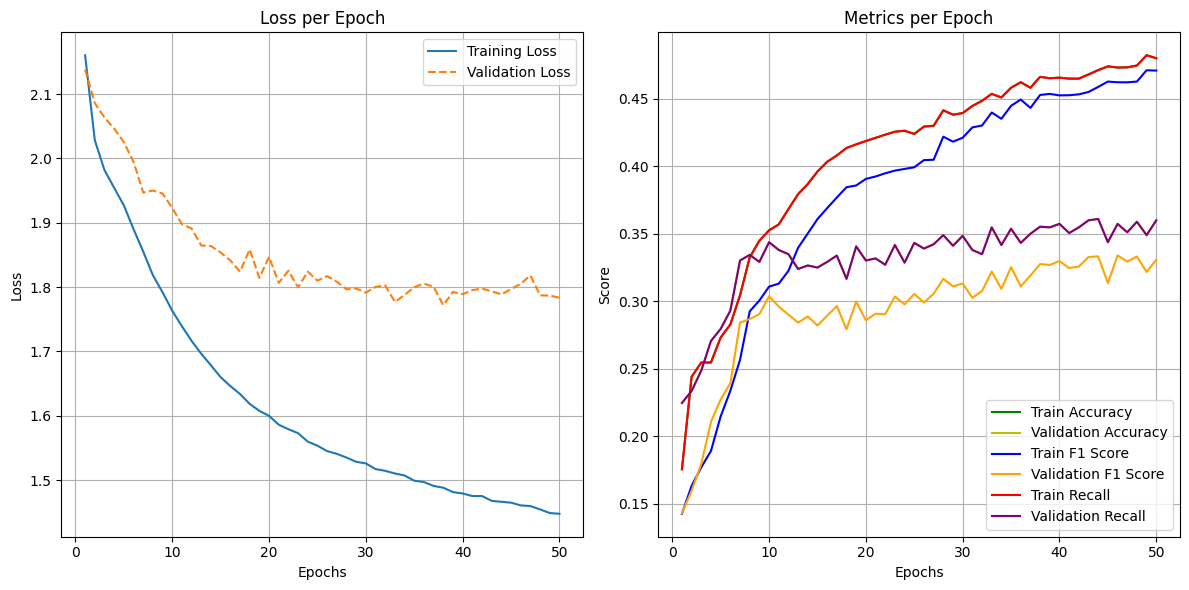

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, f1_score, recall_score
import matplotlib.pyplot as plt
from models import ComplexGRUModel,ComplexLSTMModel,ImprovedGRUModel,AudioLSTM,AttGRUModel,GRU
from visualizations import plot_DL_results


# Verificar si hay GPUs disponibles
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device.type == 'cuda':
    print(f"Entrenando en GPU: {torch.cuda.get_device_name(0)}")
else:
    print("No hay GPUs disponibles. El entrenamiento se realizará en la CPU.")
""" 
# Definir los parámetros del modelo
input_dim = X_train_padded.shape[2]  # Número de características de entrada
hidden_dim = 256  # Dimensiones ocultas
output_dim = 10  # Número de salidas (ajustar según necesidad)
n_layers = 2  # Número de capas LSTM
dropout_rate = 0.03  # Tasa de dropout

# Inicializar el modelo
model = AudioLSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, n_layers=n_layers, dropout_rate=dropout_rate).to(device)


# Inicialización del modelo
model = ComplexLSTMModel(input_dim=X_train_padded.shape[2], 
                        hidden_dim1=128,   # Reducir el tamaño de las capas
                        hidden_dim2=64, 
                        hidden_dim3=64, 
                        output_dim=10,dropout_rate=0.1).to(device)

# Inicialización del modelo GRU
model = ComplexGRUModel(input_dim=X_train_padded.shape[2], # antes era 2
                        hidden_dim1=32,   # Reducir el tamaño de las capas
                        hidden_dim2=18, 
                        hidden_dim3=8, 
                        output_dim=10,dropout_rate=0.01).to(device)


# Inicialización del modelo GRU


model = AttGRUModel(input_dim=X_train_padded.shape[2], # antes era 2
                        hidden_dim1= 64,   # Reducir el tamaño de las capas
                        hidden_dim2= 64,
                        output_dim=10,dropout_rate=0.03,num_heads=4).to(device)

model = ImprovedGRUModel(input_dim=X_train_padded.shape[2], # antes era 2
                        hidden_dim1= 8,   # Reducir el tamaño de las capas
                        hidden_dim2= 8,
                        output_dim=10,dropout_rate=0.1).to(device)
                        """



model = GRU(input_dim=X_train_padded.shape[2], # antes era 2
                        hidden_dim1= 8,   # Reducir el tamaño de las capas
                        hidden_dim2= 8,
                        output_dim=10).to(device)

# Definir el optimizador con regularización L2 (weight decay)
optimizer = optim.Adam(model.parameters(), lr=0.0005,weight_decay=1e-4)# weight_decay=1e-4

criterion = nn.CrossEntropyLoss()

# Preparación de datos (convertir etiquetas y inputs en tensores)
y_train2 = torch.tensor(y_train).argmax(dim=1).to(device)
train_data = TensorDataset(torch.tensor(X_train_padded, dtype=torch.float32).to(device), y_train2)
train_loader = DataLoader(train_data, batch_size=8, shuffle=True)

# Convertir X_test y y_test a tensores y moverlos a la GPU
y_test2 = torch.tensor(y_test)  # Convertir de numpy.ndarray a torch.Tensor
y_test2 = torch.argmax(y_test2, dim=1)  # Convertir a índices si es one-hot
y_test2 = y_test2.to(device)  # Mover a la GPU

# Crear el DataLoader para los datos de prueba
test_data = TensorDataset(
    torch.tensor(X_test_padded, dtype=torch.float32).to(device),  # Mover los datos de entrada de prueba a la GPU
    y_test2  # Las etiquetas de prueba ya están en la GPU
)
test_loader = DataLoader(test_data, batch_size= 8, shuffle=True)

# Definición de la función de entrenamiento
def train_model(model, train_loader, criterion, optimizer, epochs = 100):
    model.train()
    train_losses = []
    valid_losses = []
    train_accuracies = []
    train_f1_scores = []
    train_recalls = []
    valid_accuracies = []
    valid_f1_scores = []
    valid_recalls = []

    for epoch in range(epochs):
        running_loss = 0.0
        all_labels = []
        all_preds = []

        # Entrenamiento
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().tolist())
            all_preds.extend(preds.cpu().tolist())

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = accuracy_score(all_labels, all_preds)
        epoch_f1 = f1_score(all_labels, all_preds, average='weighted')
        epoch_recall = recall_score(all_labels, all_preds, average='weighted')

        # Guardar las métricas de entrenamiento
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)
        train_f1_scores.append(epoch_f1)
        train_recalls.append(epoch_recall)

        # Validación (usando el modelo en modo evaluación)
        model.eval()
        valid_loss = 0.0
        valid_labels = []
        valid_preds = []
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                valid_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                valid_labels.extend(labels.cpu().tolist())
                valid_preds.extend(preds.cpu().tolist())

            valid_loss = valid_loss / len(test_loader)
            valid_accuracy = accuracy_score(valid_labels, valid_preds)
            valid_f1 = f1_score(valid_labels, valid_preds, average='weighted')
            valid_recall = recall_score(valid_labels, valid_preds, average='weighted')

            # Guardar las métricas de validación
            valid_losses.append(valid_loss)
            valid_accuracies.append(valid_accuracy)
            valid_f1_scores.append(valid_f1)
            valid_recalls.append(valid_recall)

        model.train()  # Volver al modo entrenamiento

        print(f"Epoch {epoch+1}/{epochs} - Loss: {epoch_loss:.4f} - Train Accuracy: {epoch_accuracy:.4f} - Train F1: {epoch_f1:.4f} - Train Recall: {epoch_recall:.4f} - Valid Loss: {valid_loss:.4f} - Valid Acc: {valid_accuracy:.4f}")

    return (train_losses, valid_losses, train_accuracies, train_f1_scores, train_recalls,
            valid_accuracies, valid_f1_scores, valid_recalls)

epochs = 50
# Entrenar el modelo
train_losses, valid_losses, train_accuracies, train_f1_scores, train_recalls, valid_accuracies, valid_f1_scores, valid_recalls = train_model(
    model, train_loader, criterion, optimizer, epochs = epochs)

# Graficar las métricas
epochs_range = range(1, epochs+1)


# Llamada a la función para graficar los resultados
plot_DL_results(
    train_accuracies=train_accuracies,
    valid_accuracies=valid_accuracies,
    train_losses=train_losses,
    valid_losses=valid_losses,
    train_f1_scores=train_f1_scores,
    valid_f1_scores=valid_f1_scores,
    train_recalls=train_recalls,
    valid_recalls=valid_recalls,
    epochs_range=epochs_range
)